#Skin_Disease_Detection_Code

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, optimizers, models

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_data_path="/content/drive/MyDrive/Skin Dataset/train"

In [8]:
names=os.listdir(train_data_path)
names

['Seborrheic Keratoses', 'Bullous Disease Photos', 'Warts Molluscum']

In [9]:
count=0
for name in names:
    size=len(os.listdir(os.path.join(train_data_path, name)))
    count+=size
print("Total Training Images: ", count)

Total Training Images:  533


# Data Pre Processing

# Using ImageDataGenerator to read images from directories

In [10]:
datagenerator=ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

In [18]:
train_gen= datagenerator.flow_from_directory(
                                              train_data_path,
                                              batch_size=15,
                                              target_size=(220,220),
                                              class_mode='categorical'
                                            )

Found 533 images belonging to 3 classes.


In [44]:
labels=train_gen.class_indices
labels

{'Bullous Disease Photos': 0, 'Seborrheic Keratoses': 1, 'Warts Molluscum': 2}

In [45]:
pre_trained_model=InceptionV3(input_shape=(220,220,3),  include_top=False,  weights='imagenet')

In [46]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [47]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 109, 109, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 109, 109, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [48]:
last_layer=pre_trained_model.get_layer('mixed7')

print("Last layer Output Shape: ", last_layer.output_shape)

last_output= last_layer.output

Last layer Output Shape:  (None, 12, 12, 768)


# Creating Network Architecture

In [49]:
x=layers.Flatten()(last_output)
x=layers.Dense(128, activation='relu')(x)
x=layers.Dropout(0.4)(x)
x=layers.Dense(32, activation='relu')(x)
x=layers.Dropout(0.3)(x)
x=layers.Dense(3, activation='softmax')(x)

model=models.Model(pre_trained_model.input, x)

In [50]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 109, 109, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 109, 109, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [51]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") is not None and logs.get('accuracy')>=0.95:
            print("\n Reached 95 val accuracy so cancelling training")
            self.model.stop_training=True

callbacks=mycallback()

# Training

In [53]:
history=model.fit(train_gen, epochs=100, callbacks=[callbacks])

Epoch 1/100
36/36 [==============================] - 15s 268ms/step - loss: 0.9793 - accuracy: 0.5704
Epoch 2/100
36/36 [==============================] - 10s 289ms/step - loss: 0.7805 - accuracy: 0.6492
Epoch 3/100
36/36 [==============================] - 10s 291ms/step - loss: 0.6892 - accuracy: 0.6961
Epoch 4/100
36/36 [==============================] - 11s 300ms/step - loss: 0.6446 - accuracy: 0.6979
Epoch 5/100
36/36 [==============================] - 9s 259ms/step - loss: 0.5895 - accuracy: 0.7392
Epoch 6/100
36/36 [==============================] - 10s 293ms/step - loss: 0.5911 - accuracy: 0.7636
Epoch 7/100
36/36 [==============================] - 11s 295ms/step - loss: 0.5715 - accuracy: 0.7786
Epoch 8/100
36/36 [==============================] - 10s 291ms/step - loss: 0.5420 - accuracy: 0.7580
Epoch 9/100
36/36 [==============================] - 11s 298ms/step - loss: 0.4921 - accuracy: 0.7936
Epoch 10/100
36/36 [==============================] - 11s 303ms/step - loss: 0.5004

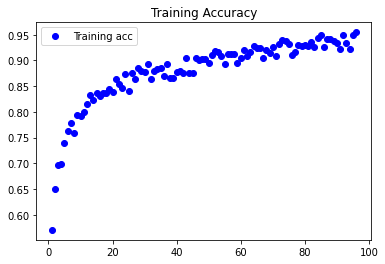

In [54]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training Accuracy')
plt.legend()
plt.show()

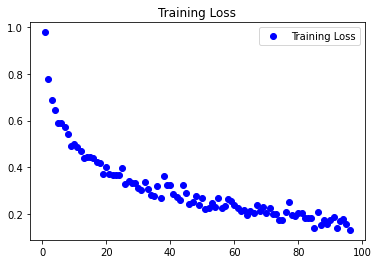

In [55]:
loss=history.history['loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [56]:
model.save("/content/drive/MyDrive/Skin Disease Model 4.h5")

In [57]:
test_data_path="/content/drive/MyDrive/Skin Dataset/test"

In [58]:
test_generator=datagenerator.flow_from_directory(
                                            test_data_path,
                                            batch_size=2,
                                            target_size=(220,220),
                                            class_mode='categorical'
                                            )

Found 18 images belonging to 3 classes.


In [59]:
loss,acc= model.evaluate(test_generator)

9/9 [==============================] - 1s 44ms/step - loss: 0.0847 - accuracy: 1.0000


In [60]:
print("Test Data Loss: ",loss)
print("Test Data Accuracy: ",acc)

Test Data Loss:  0.08466411381959915
Test Data Accuracy:  1.0
